# Exploratory Data Analysis

In [1]:
! pip install librosa
! pip install nltk
! pip install gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.1 MB/s eta 0:00:00


In [ ]:
# package imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import random
from scipy.io import wavfile as wav
import noisereduce as nr
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import re
nltk.download('stopwords')
nltk.download('punkt')
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from scipy.spatial.distance import cosine

from gensim.models import Word2Vec
import numpy as np
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
from gensim.models import KeyedVectors

from scipy.io import wavfile


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vivianzhao/nltk_data...


KeyboardInterrupt: 

## Load Data

In [ ]:
data_id = pd.read_csv("full_id.csv")
wav_folder = 'new_all'
sample_file = 'new_all/1.wav'
sample_data, sample_sample_rate = librosa.load(sample_file)

In [ ]:
data_id.head()

,sarcasm,text,label,emotion,id
0,0,Didn't have to tell you that Somebody's a Jan...,0,anger,1
1,0,already respects the bucket.,0,anger,2
2,0,"I accept all those flaws, why can't you accep...",0,anger,3
3,0,"This is my wife Nancy. Look, get out!",0,anger,4
4,0,Fine! Then you tell Roger because he was real...,0,anger,5


# Text Analysis

# Audio Analysis

### Shrink all to monofiles

In [ ]:
# Lists to store filenames by channel type
mono_files = []
stereo_files = []
multi_channel_files = []

# Check each .wav file in the directory
for file in os.listdir(wav_folder):
    if file.endswith('.wav'):
        file_path = os.path.join(wav_folder, file)
        
        try:
            sample_rate, audio_data = wavfile.read(file_path)
            
            # Check if mono (1 channel)
            if audio_data.ndim == 1 or (audio_data.ndim == 2 and audio_data.shape[1] == 1):
                mono_files.append(file)
            
            # Check if stereo (2 channels)
            elif audio_data.ndim == 2 and audio_data.shape[1] == 2:
                stereo_files.append(file)
            
            # Check if multi-channel (3 or more channels)
            elif audio_data.ndim == 2 and audio_data.shape[1] >= 3:
                multi_channel_files.append(file)
                
        except Exception as e:
            print(f"Error reading {file}: {e}")

# Print the counts and store file lists
print("\nSummary:")
print(f"Mono files (1 channel): {len(mono_files)}")
print(f"Stereo files (2 channels): {len(stereo_files)}")
print(f"Multi-channel files (3 or more channels): {len(multi_channel_files)}")

In [ ]:
### Lets read with scipy
mono_wave_sr, mono_wave_audio = wav.read('new_all/' + mono_files[0]) 

# Original audio with 1 channels 
plt.figure(figsize=(12, 4))
plt.plot(mono_wave_audio)

In [ ]:
stereo_wave_sr, stereo_wave_audio = wav.read('new_all/' + stereo_files[0]) 

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(stereo_wave_audio)

### Noise Reduction

In [ ]:
sample_data_denoised = nr.reduce_noise(y=sample_data, sr=sample_sample_rate)

In [ ]:
# Assuming 'sample_file_denoised' and 'data' are already loaded, and 'sample_rate' is defined

plt.figure(figsize=(14, 5))

# Plot the original waveform
plt.subplot(1, 2, 1)
librosa.display.waveshow(sample_data, sr=sample_sample_rate)
plt.title('Waveform (Original)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot the denoised waveform
plt.subplot(1, 2, 2)
librosa.display.waveshow(sample_data_denoised, sr=sample_sample_rate)
plt.title('Waveform (Denoised)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Play both audio files
print("Original Audio:")
ipd.display(ipd.Audio(sample_data, rate=sample_sample_rate))  # Play original audio

print("Denoised Audio:")
ipd.display(ipd.Audio(sample_data_denoised, rate=sample_sample_rate))  # Play denoised audio

In [ ]:
import os
import librosa
import noisereduce as nr
import soundfile as sf

# Define input and output folders
input_folder = 'new_all'  # Replace with your actual input folder path
output_folder = 'audio_data'  # Replace with your actual output folder path

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Process each .wav file in the input folder
for file_name in os.listdir(input_folder):
    if file_name.endswith('.wav'):
        input_path = os.path.join(input_folder, file_name)
        output_path = os.path.join(output_folder, file_name)

        try:
            # Load audio file
            data, sample_rate = librosa.load(input_path, sr=None)

            # Apply noise reduction
            reduced_noise = nr.reduce_noise(y=data, sr=sample_rate)

            # Save the noise-reduced audio
            sf.write(output_path, reduced_noise, sample_rate)

            print(f"Processed and saved: {output_path}")
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

### Plotting Audio Features

In [ ]:
# Graph Functions

# Load audio file and extract features
def load_audio_features(file_id):
    file_path = os.path.join("audio_data", f"{file_id}.mp3")
    y, sr = librosa.load(file_path)
    return y, sr

# Plot waveform
def plot_waveform(y1, sr1, y2, sr2, label1="File 1", label2="File 2", title="Waveform Comparison"):
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y1, sr=sr1)
    plt.title(f'{title} - {label1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    
    plt.subplot(1, 2, 2)
    librosa.display.waveshow(y2, sr=sr2)
    plt.title(f'{title} - {label2}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

# Plot spectrogram
def plot_spectrogram(y1, sr1, y2, sr2, label1="File 1", label2="File 2", title="Spectrogram Comparison"):
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    D1 = librosa.amplitude_to_db(np.abs(librosa.stft(y1)), ref=np.max)
    librosa.display.specshow(D1, sr=sr1, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'{title} - {label1}')
    
    plt.subplot(1, 2, 2)
    D2 = librosa.amplitude_to_db(np.abs(librosa.stft(y2)), ref=np.max)
    librosa.display.specshow(D2, sr=sr2, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'{title} - {label2}')
    plt.show()

# Plot MFCC
def plot_mfcc(y1, sr1, y2, sr2, label1="File 1", label2="File 2", title="MFCC Comparison"):
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    mfccs1 = librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=13)
    librosa.display.specshow(mfccs1, x_axis='time')
    plt.colorbar()
    plt.title(f'{title} - {label1}')
    
    plt.subplot(1, 2, 2)
    mfccs2 = librosa.feature.mfcc(y=y2, sr=sr2, n_mfcc=13)
    librosa.display.specshow(mfccs2, x_axis='time')
    plt.colorbar()
    plt.title(f'{title} - {label2}')
    plt.show()

# Plot Chromagram
def plot_chromagram(y1, sr1, y2, sr2, label1="File 1", label2="File 2", title="Chromagram Comparison"):
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    chroma1 = librosa.feature.chroma_stft(y=y1, sr=sr1)
    librosa.display.specshow(chroma1, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title(f'{title} - {label1}')
    
    plt.subplot(1, 2, 2)
    chroma2 = librosa.feature.chroma_stft(y=y2, sr=sr2)
    librosa.display.specshow(chroma2, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title(f'{title} - {label2}')
    plt.show()

# Function to sample two audio files based on sentiment
def sample_by_sentiment(df):
    positive_sample = df[df['label'] == 1].sample(1, random_state=random.seed()).iloc[0]
    negative_sample = df[df['label'] == 0].sample(1, random_state=random.seed()).iloc[0]
    return positive_sample['id'], negative_sample['id']

# Function to sample two audio files based on sarcasm
def sample_by_sarcasm(df):
    sarcasm_sample = df[df['sarcasm'] == 1].sample(1, random_state=random.seed()).iloc[0]
    non_sarcasm_sample = df[df['sarcasm'] == 0].sample(1, random_state=random.seed()).iloc[0]
    return sarcasm_sample['id'], non_sarcasm_sample['id']


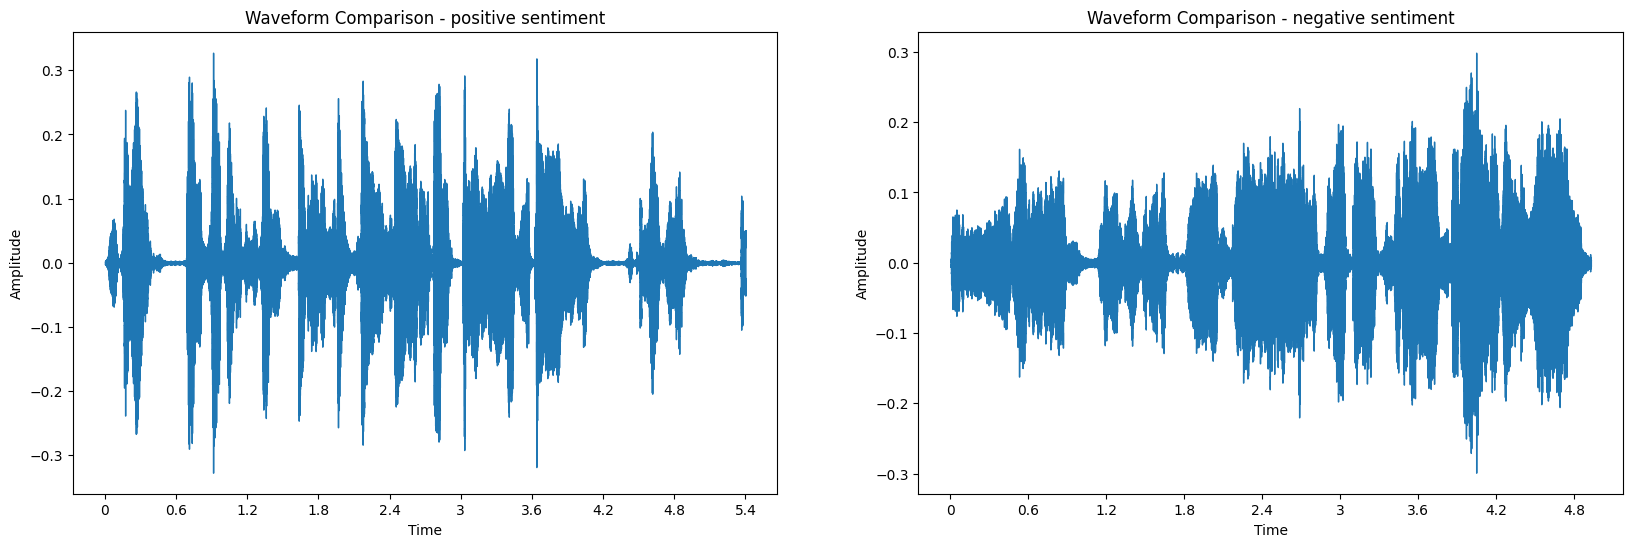

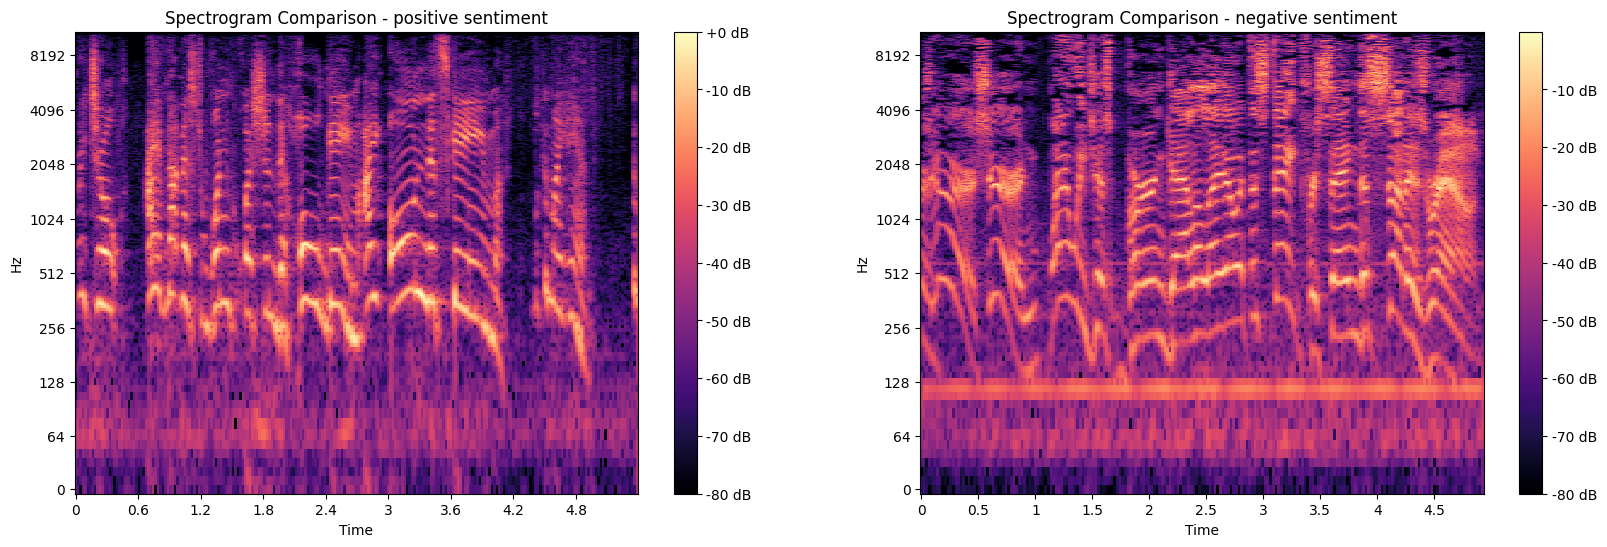

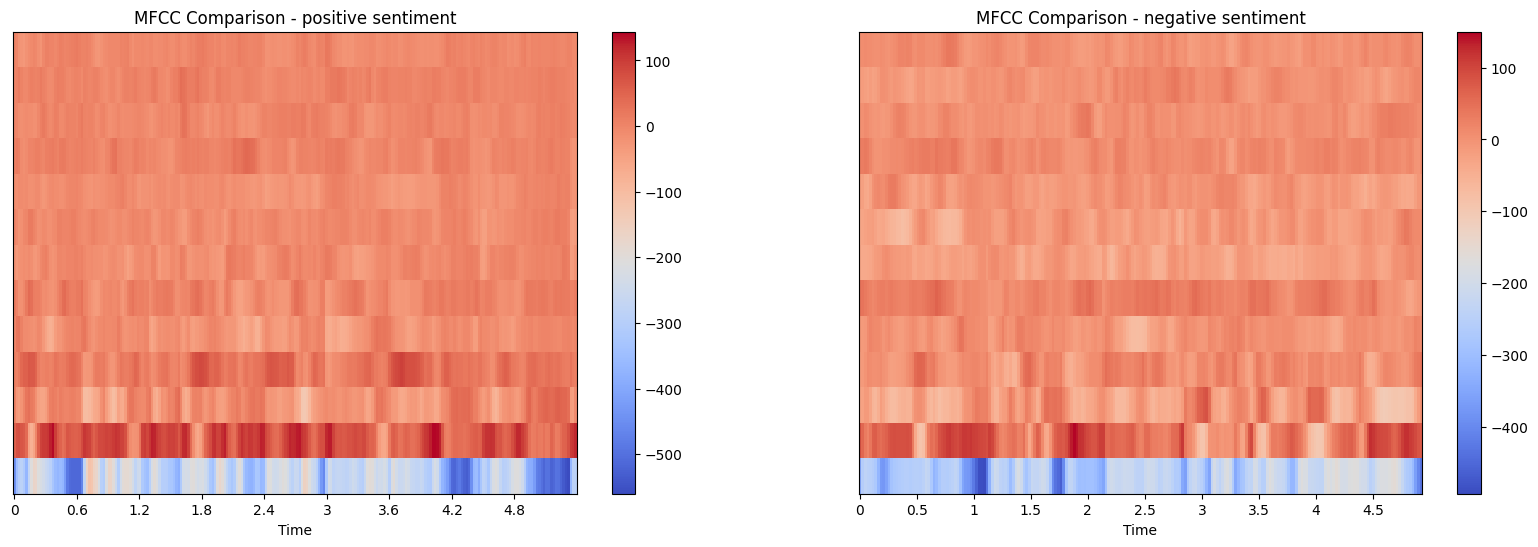

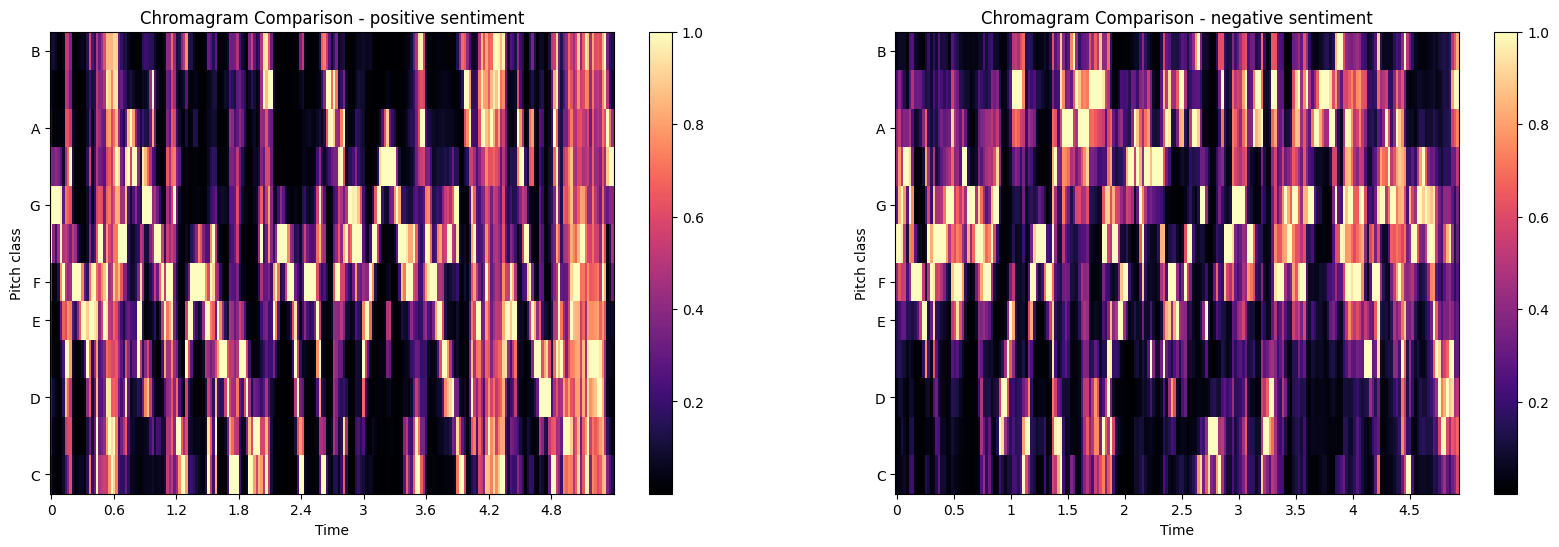

In [ ]:
#sample sentiment data
positive, negative = sample_by_sentiment(data_id)


y1, sr1 = load_audio_features(positive) 
y2, sr2 = load_audio_features(negative) 
custom_label1 = "positive sentiment" 
custom_label2 = "negative sentiment" 

# Plot each set of features
plot_waveform(y1, sr1, y2, sr2, custom_label1, custom_label2)
plot_spectrogram(y1, sr1, y2, sr2, custom_label1, custom_label2)
plot_mfcc(y1, sr1, y2, sr2, custom_label1, custom_label2)
plot_chromagram(y1, sr1, y2, sr2, custom_label1, custom_label2)

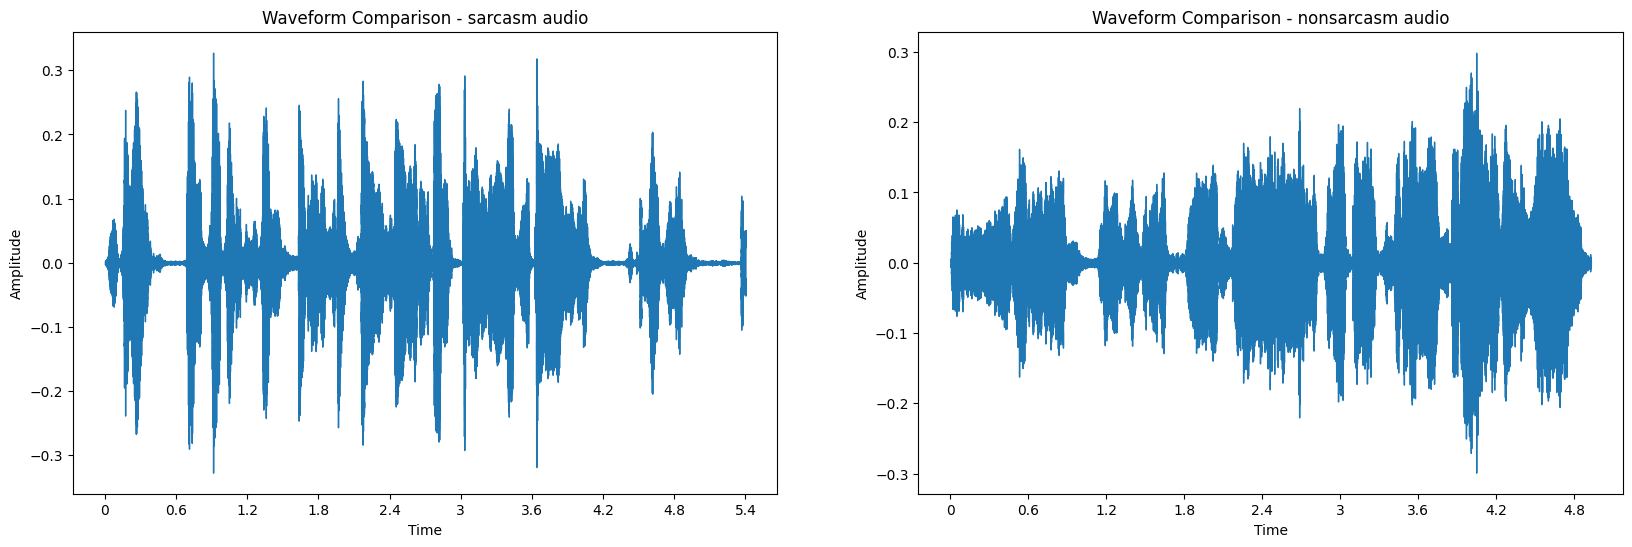

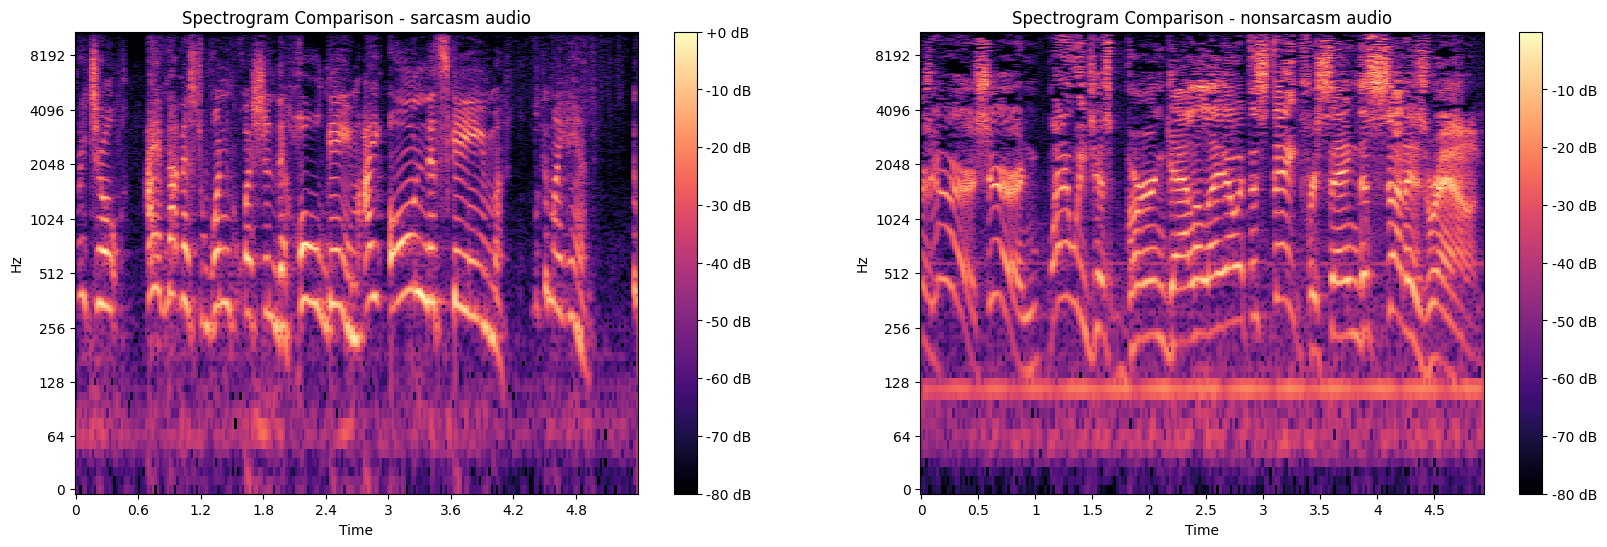

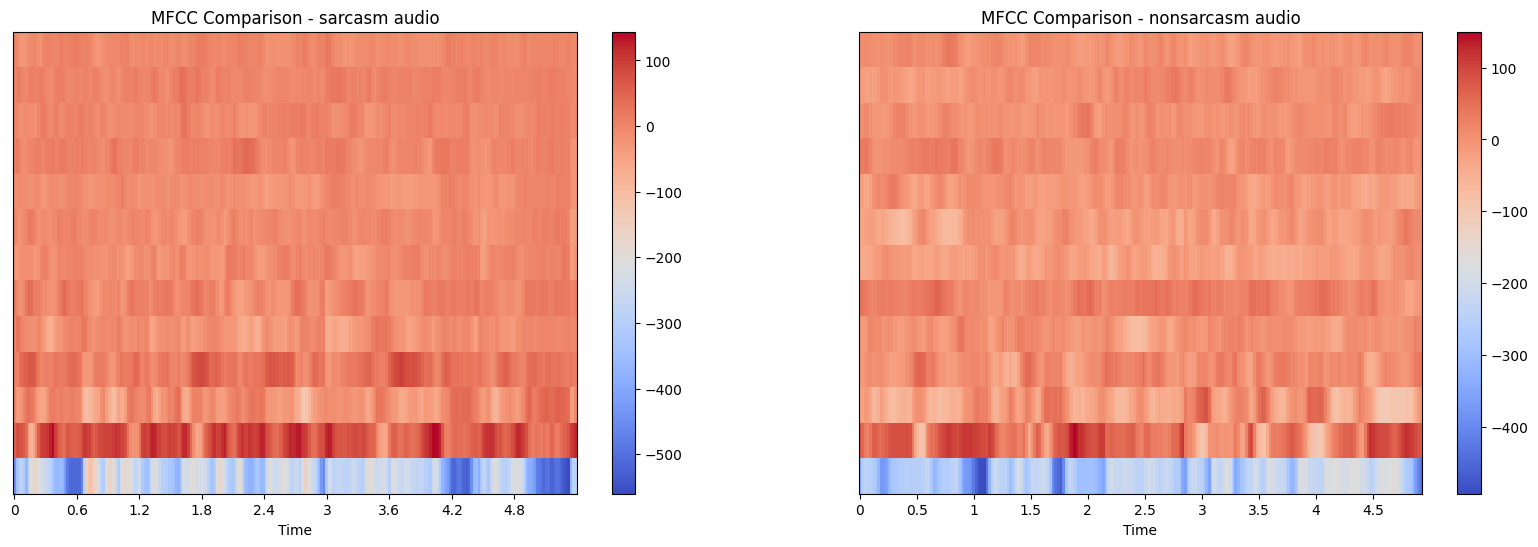

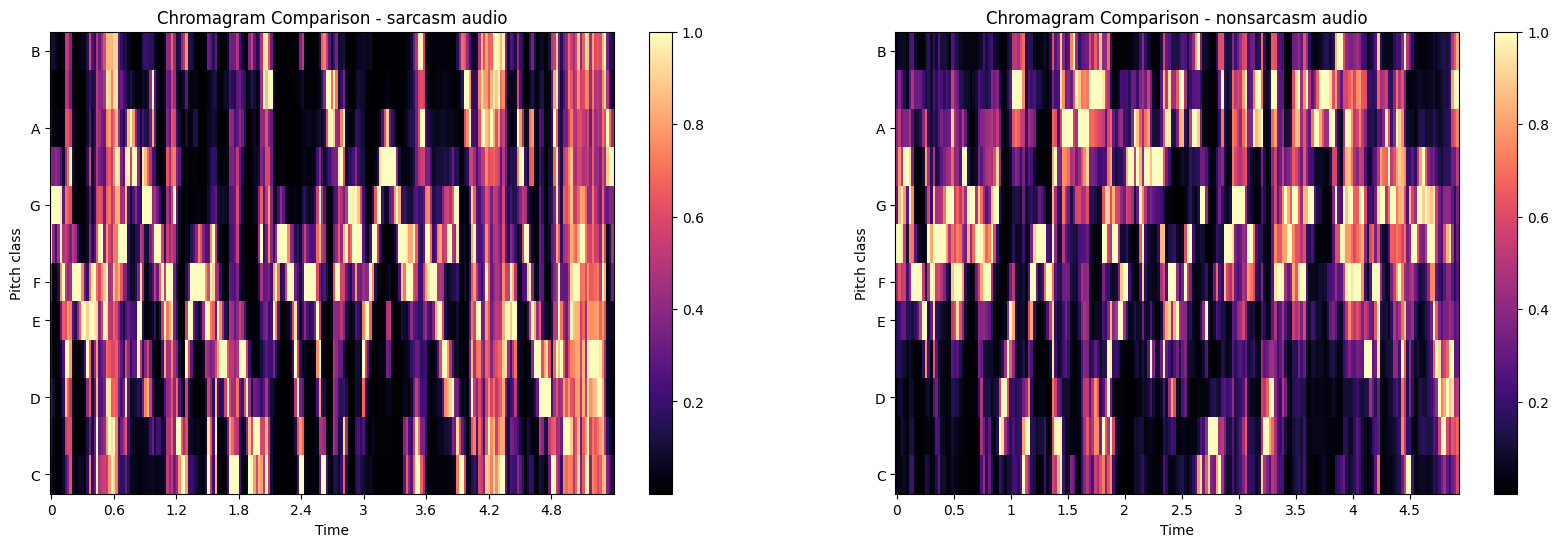

In [ ]:
#sample sentiment data
sarcasm, nonsarcasm = sample_by_sarcasm(data_id)


y1, sr1 = load_audio_features(positive) 
y2, sr2 = load_audio_features(negative) 
custom_label1 = "sarcasm audio" 
custom_label2 = "nonsarcasm audio" 

# Plot each set of features
plot_waveform(y1, sr1, y2, sr2, custom_label1, custom_label2)
plot_spectrogram(y1, sr1, y2, sr2, custom_label1, custom_label2)
plot_mfcc(y1, sr1, y2, sr2, custom_label1, custom_label2)
plot_chromagram(y1, sr1, y2, sr2, custom_label1, custom_label2)